# Intuition - Decision Trees

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


## Paper Exercise

Let us start with a simple exercise in classifying credit risk. 

We have the following features in our dataset. 
- Risk - ordinal (label)
- Income - continuous
- Credit History - ordinal


We want to find out the rules that would help us classify the three risk type - This is a paper and pen exercise first!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (9,6)

In [2]:
df = pd.read_csv("data/creditRisk.csv")

In [3]:
df.head()

,Income,Credit History,Risk
0,0,Unknown,High
1,0,Bad,High
2,0,Good,High
3,14000,Unknown,High
4,14000,Bad,High


## Plotting the Data

In [4]:
import seaborn as sns

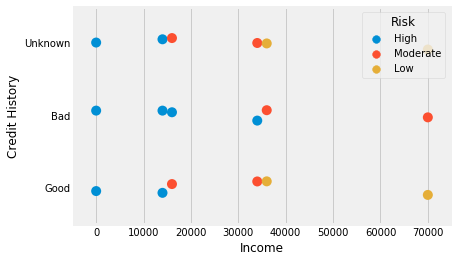

In [5]:
sns.stripplot(data = df, x = "Income", y = "Credit History", hue = "Risk", size = 10)

## Preparing Data

We have one ordinal variable (Risk) and one nominal variable (Credit History)

Lets use LabelEncoder for the nominal variable

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [7]:
df['Credit History'].unique()

array(['Unknown', 'Bad', 'Good'], dtype=object)

In [8]:
df['Credit History'].unique()

array(['Unknown', 'Bad', 'Good'], dtype=object)

In [9]:
le.fit(df['Credit History'].unique())

LabelEncoder()

In [10]:
df['Credit History'].tail()

13        Bad
14       Good
15    Unknown
16        Bad
17       Good
Name: Credit History, dtype: object

In [11]:
# Converting the categorical data using label encoder
df['Credit History'] = le.transform(df['Credit History'])

In [12]:
df['Credit History'].tail()

13    0
14    1
15    2
16    0
17    1
Name: Credit History, dtype: int64

In [13]:
le.classes_

array(['Bad', 'Good', 'Unknown'], dtype=object)

Lets use a dictionary for encoding nominal variable

In [14]:
df.Risk.unique()

array(['High', 'Moderate', 'Low'], dtype=object)

In [15]:
Risk_mapping = {
       'High': 2,
       'Moderate': 1,
       'Low': 0}

In [16]:
df.Risk.tail()

13    Moderate
14         Low
15         Low
16    Moderate
17         Low
Name: Risk, dtype: object

In [17]:
df['Risk'] = df['Risk'].map(Risk_mapping)

In [18]:
df.Risk.tail()

13    1
14    0
15    0
16    1
17    0
Name: Risk, dtype: int64

In [19]:
df.head()

,Income,Credit History,Risk
0,0,2,2
1,0,0,2
2,0,1,2
3,14000,2,2
4,14000,0,2


## Decision Tree Classifier

In [20]:
data = df.iloc[:,0:2]
target = df.iloc[:,2:3]

In [21]:
from sklearn import tree

In [22]:
clf = tree.DecisionTreeClassifier()

In [23]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [24]:
clf = clf.fit(data, target)

## Visualise the Tree

In [25]:
import pydotplus 
from IPython.display import Image

In [26]:
dot_data = tree.export_graphviz(clf, out_file='tree.dot', feature_names=data.columns,
                                class_names=['Low', 'Moderate', 'High'], filled=True, 
                                rounded=True, special_characters=True)

In [27]:
graph = pydotplus.graph_from_dot_file('tree.dot')  

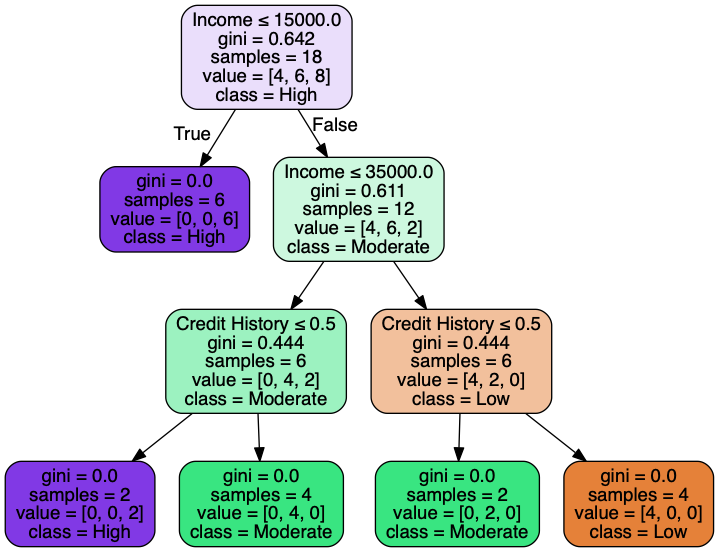

In [28]:
Image(graph.create_png()) 

In [29]:
import modelvis

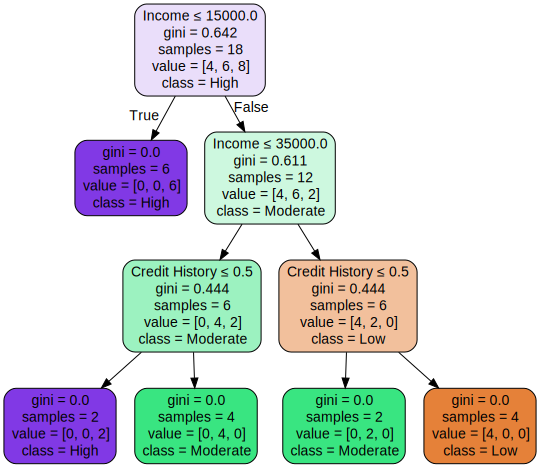

In [30]:
modelvis.render_tree(clf, feature_names=data.columns,class_names=['Low', 'Moderate', 'High'] )

In [31]:
modelvis.print_tree_as_code(clf)

def predict(row):
    """Your decision-tree model wrote this code."""
    # 18 samples; value=[4, 6, 8]; class=2
    if row[0] < 15000.0:
        # 6 samples; value=[0, 0, 6]; class=2
        return 2
    else:
        # 12 samples; value=[4, 6, 2]; class=1
        if row[0] < 35000.0:
            # 6 samples; value=[0, 4, 2]; class=1
            if row[1] < 0.5:
                # 2 samples; value=[0, 0, 2]; class=2
                return 2
            else:
                # 4 samples; value=[0, 4, 0]; class=1
                return 1
        else:
            # 6 samples; value=[4, 2, 0]; class=0
            if row[1] < 0.5:
                # 2 samples; value=[0, 2, 0]; class=1
                return 1
            else:
                # 4 samples; value=[4, 0, 0]; class=0
                return 0



Now we need to first define an Impurity measure. The three popular impurity measures are:
    - Gini Impurity
    - Entropy
    - Classification Error
    
Gini Impurity and Entropy lead to similiar results when growing the tree, while Classification error is not as useful for growing the tree (but for pruning the tree) - See example here http://sebastianraschka.com/faq/docs/decision-tree-binary.html

Lets understand Gini Impurity a little better. Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset,  Gini impurity can be computed by summing the probability $t_{i} $ of an item with label $i$ being chosen times the probability $ 1-t_{i}$ of a mistake in categorizing that item.

$$ I_{G}(f)=\sum _{i=1}^{J}t_{i}(1-t_{i})=\sum _{i=1}^{J}(t_{i}-{t_{i}}^{2})=\sum _{i=1}^{J}t_{i}-\sum _{i=1}^{J}{t_{i}}^{2}=1-\sum _{i=1}^{J}{t_{i}}^{2} $$

#### Lets calculate the Gini for the overall data set:

Low - 4, Moderate - 6, High - 8 and total observations are 18 

$$ I_G(t) = 1 - \left(\frac{6}{18}\right)^2 - \left(\frac{4}{18}\right)^2 - \left(\frac{8}{18}\right)^2 = 1 - \frac{116}{256} = 0.642 $$

scikit-learn uses an optimized CART algorithm, which will use a greedy approach.  A greedy approach is used to divide the space called recursive binary splitting. This is a numerical procedure where all the values are lined up and different split points are tried and tested using a objective cost function. The split with the best cost (lowest cost because we minimize cost) is selected.

Another way to think of this is that a learned binary tree is actually a partitioning of the input space. You can think of each input variable as a dimension on an p-dimensional space. The decision tree split this up into rectangles (when p=2 input variables) or some kind of hyper-rectangles with more inputs. 

We can draw these partitions for our dataset

In [240]:
def plot_classifier_2d(clf, data, target):
    x_min, x_max = data.iloc[:,0].min(), data.iloc[:,0].max()
    y_min, y_max = data.iloc[:,1].min(), data.iloc[:,1].max()
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, (x_max - x_min)/100), 
        np.arange(y_min, y_max, (y_max - y_min)/100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="viridis", alpha = 0.5)
    plt.colorbar(cs)
    plt.scatter(x = data.iloc[:,0], y = data.iloc[:,1], c = target, s = 100, cmap="magma")


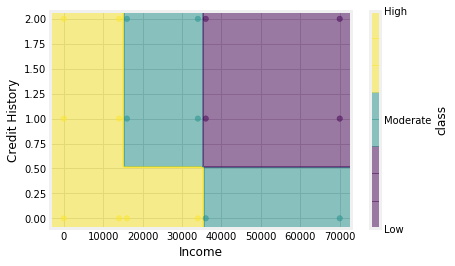

In [41]:
modelvis.plot_decision_boundaries(clf, data, target, feature_names=data.columns, show_input=True,
                                  class_names=['Low', 'Moderate', 'High'])

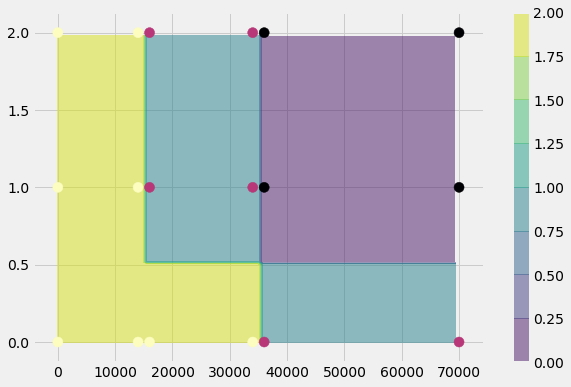

In [239]:
plot_classifier_2d(clf, data,target)

**Stop growing the tree**

- The obvious point to stop growing the tree is when the Gini Impurity = 0, that is there is only one label left in a node
- Another option is to define a max_depth of the tree, though this may lead to suboptimal trees.
- The most common stopping procedure is to use a minimum count on the number of training instances assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

## Trees - Advantages and Disadvantages

Advantages of Trees
- **Simple** to understand and interpret.
- Requires **little data prep**. No need for data normalisation, dummy variables, missing values to be removed.
- Able to handle **both numerical and categorical data**. 
- Uses a **white box** model. With simple clear rules
- Can be **easily validated**
- **Scales well** with data

Disadvantages of Trees
- **Overfitting**: over-complex trees that do not generalise data well. 
- **Unstable** because small variations in the data result in a  different tree
- **Locally Optimal**: Tree is known to be NP-complete and hence need heuristics like greedy algorithm (locally optimal but may not be globally optimal)
- **Biased Trees**: Not good learner if one class dominates.